Import spatial data in AnnData and Squidpy
==========================================

This tutorial shows how to store spatial datasets in :class:`anndata.AnnData`.

Spatial molecular data comes in many different formats, and to date there is no
one-size-fit-all solution for reading spatial data in Python.
Scanpy already provides a solution for Visium Spatial transcriptomics data with
the function :func:`scanpy.read_visium` but that is basically it.
Here in Squidpy, we do provide some pre-processed (and pre-formatted) datasets,
with the module :mod:`squidpy.datasets` but it's not very useful for the users
who need to import their own data.

In this tutorial, we will showcase how spatial data are stored in :class:`anndata.AnnData`.
We will use mock datasets for this purpose, yet showing with examples the important
details that you should take care of in order to exploit the full functionality of the
*AnnData-Scanpy-Squidpy* ecosystem.

In [2]:
from anndata import AnnData
import scanpy as sc
import squidpy as sq
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

/home/marvin/anaconda3/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/marvin/anaconda3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/marvin/anaconda3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit de

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.4 scipy==1.10.1 pandas==2.1.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10
squidpy==1.3.1


/home/marvin/anaconda3/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Spatial coordinates in AnnData
------------------------------
First, let's generate some data. We will need:

  - an array of features (e.g. counts).
  - an array of spatial coordinates.
  - an image array (e.g. the tissue image).

In [3]:
rng = default_rng(42)
counts = rng.integers(0, 15, size=(10, 100))  # feature matrix
coordinates = rng.uniform(0, 10, size=(10, 2))  # spatial coordinates
image = rng.uniform(0, 1, size=(10, 10, 3))  # image

In [14]:
counts[0], coordinates[0]

(array([ 1, 11,  9,  6,  6, 12,  1, 10,  3,  1,  7, 14, 11, 11, 10, 11,  7,
         1, 12,  6,  7,  5,  2, 13, 11,  9,  6, 12,  8,  6,  6,  3,  1,  8,
        13,  0, 12, 12,  4,  9,  2, 11, 10,  5,  1, 14,  6, 13, 10, 11, 11,
         2,  5,  7,  7,  0,  8,  2, 11, 10, 13, 11,  5, 14,  6,  4, 13,  5,
         1,  7, 11,  2,  6,  1, 10,  7,  4,  3,  8, 10, 14,  6,  2, 12,  9,
        10,  1,  4, 11, 12,  6, 12, 12,  5, 13,  4,  3, 10,  9,  2]),
 array([7.36705688, 8.86402887]))

Let's first start with creating the :class:`anndata.AnnData` object.
We will first just use the count matrix and the spatial coordinates.
Specify the :attr:`anndata.AnnData.obsm` key as `'spatial'` is not strictly necessary
but will save you a lot of typing since it's the default for both Squidpy and Scanpy.

In [4]:
adata = AnnData(counts, obsm={"spatial": coordinates}, dtype=np.int64)

Next, let's run a standard Scanpy clustering and umap workflow.

In [5]:
sc.pp.normalize_total(adata) # normalize is done for counts. if you have other data types, you would rather do scaling for instance via min/max
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

AnnData object with n_obs × n_vars = 10 × 100
    obs: 'leiden'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
adata.obsm

AxisArrays with keys: spatial, X_pca, X_umap

We can visualize the dummy cluster annotation ``adata.obs['leiden']`` in space.

/home/marvin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/marvin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


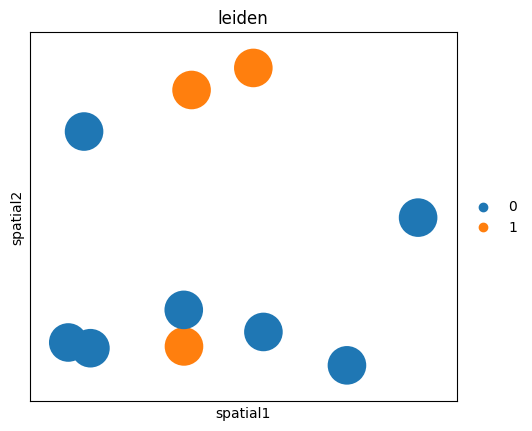

In [6]:
sc.pl.spatial(adata, color="leiden", spot_size=1)

Tissue image in AnnData
-----------------------
For use cases where there is no tissue image, this is all you need
to start using Scanpy/Squidpy for your analysis.
For instance, you can compute a spatial graph with :func:`squidpy.gr.spatial_neighbors`
based on a fixed neighbor radius that is informative given your experimental settings.

Here, in sq.gr.spatial_neighbors they choose radius = 3.0 for a neighbor radius of 3.
this is in units of spacial coordinates of the underlying dataset, see [here](https://squidpy.readthedocs.io/en/stable/notebooks/examples/graph/compute_spatial_neighbors.html)
"Generic" is for non-Visium datasets.




In [8]:
#sq.gr.spatial_neighbors?

/home/marvin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/marvin/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


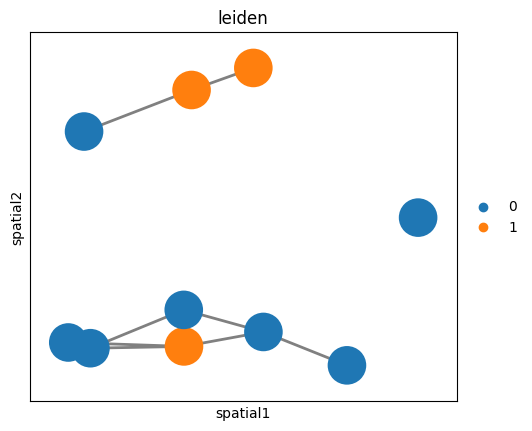

In [9]:
sq.gr.spatial_neighbors(adata, coord_type = "generic", radius=3.0)
sc.pl.spatial(adata, color="leiden", neighbors_key="spatial_neighbors", spot_size=1, edges=True, edges_width=2)

In [10]:
adata.obsp

PairwiseArrays with keys: distances, connectivities, spatial_connectivities, spatial_distances

using squidpy plotting, you have basically the same settings as in scanpy, but on top of it you have the shape parameter. Using None, it gives you a normal scatterplot, but otherwise, it produces different shapes based on the underlying methodology used. it also incorporates spacial information about the size of the observation, e.g., by checking the pixel size

In [11]:
#sq.pl.spatial_scatter?

note, that the connectivity_key is spatial_connectivities. this is important as the distances available in the adata.obsp (above) are the spacial distances in terms of pixels for instance. the connectivities are NN graphs calculated by the sc.pp.neighbors(adata) function, here in pca space.

also notice the warning regarding library_id. the library_id is needed to indicate which dataset you are referring to. when you have different samples, you have more than one library_ids such that you can plot them next to each other. thus, you have to specify the ids

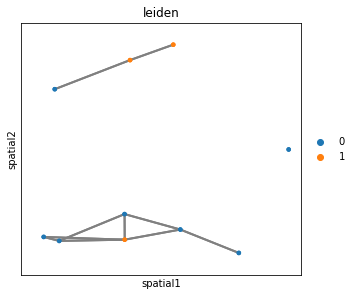

In [24]:
import squidpy as sq
sq.pl.spatial_scatter(adata, shape=None, color="leiden",size=50,connectivity_key="spatial_connectivities",edges_width=2)

In case you do have an image of the tissue (or multiple, at different resolutions)
this is what you need to know to correctly store it in AnnData.
First, let's visualize the mock image from before.

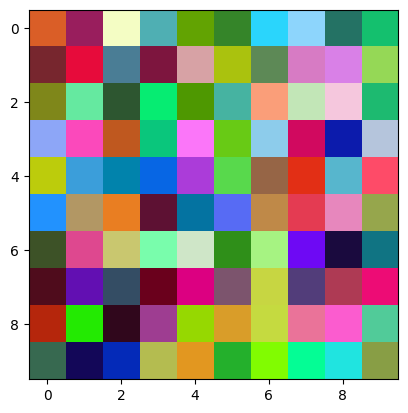

In [15]:
plt.imshow(image)

The image and its metadata are stored in the `uns` slot of :class:`anndata.AnnData`.
Specifically, in the ``adata.uns['spatial'][<library_id>]`` slot, where `library_id`
is any unique key that refers to the tissue image.

For now, we will assume that there is only one image. This is the necessary metadata:

  - `tissue_hires_scalef` - this is the scale factor between the spatial coordinates
    units and the image pixels. In the case of Visium, this is usually ~0.17. In this case,
    we assume that the spatial coordinates are in the same scale of the pixels, and so
    we will set this value to 1.
  - `spot_diameter_fullres` - this is the diameter of the capture area for each observation.
    In the case of Visium, we usually call them `"spots"` and this value is set to ~89.

Here, we will set it to 0.5.

you can also save additional images, for instance cell masks in the dictionary of the images

In [8]:
spatial_key = "spatial"
library_id = "tissue42"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": image}
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 1, "spot_diameter_fullres": 0.5}

We don't provide the flexibility (yet) to change the values of such keys.
These are the keys provided by the Space Ranger output from 10x Genomics Visium
and therefore were the first to be adopted. In the future, we might settle to
a sightly different structure.
But for now, if all such key are correct, :func:`scanpy.pl.spatial` works out of the box.

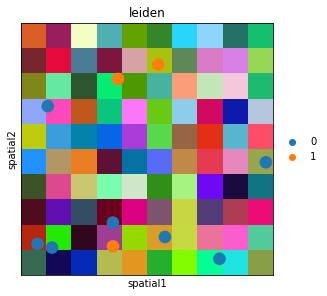

In [9]:
sq.pl.spatial_scatter(adata, color="leiden")

You can fiddle around with the settings to see what changes.
For instance, let's change `tissue_hires_scalef` to half the previous value.

__important__ notice how the parameters interact with each other: now, the coordinate system of the tissue has changed wrt to the spots. this has to be kept in mind later when transforming the image or spot data respectively. if you don't pay attention, the spots will not end up on the correct place of the image

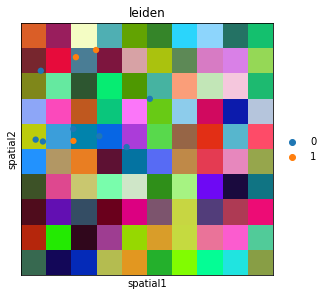

In [10]:
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 0.5, "spot_diameter_fullres": 0.5}
sq.pl.spatial_scatter(adata, color="leiden")

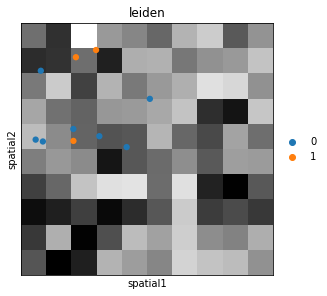

In [11]:
sq.pl.spatial_scatter(adata, color="leiden", img_cmap="gray")

As you can see, the spatial coordinates have been scaled down, and the image
was "zoomed in".

Of course, you might want to "analyze" such image. :class:`squidpy.im.ImageContainer`
comes to the rescue! Just instantiate a new object and it will work out of the box.

The idea is to have the hires tif version (input of spaceranger) in an image container, and rather have a smaller version in the anndata (png output of spaceranger)

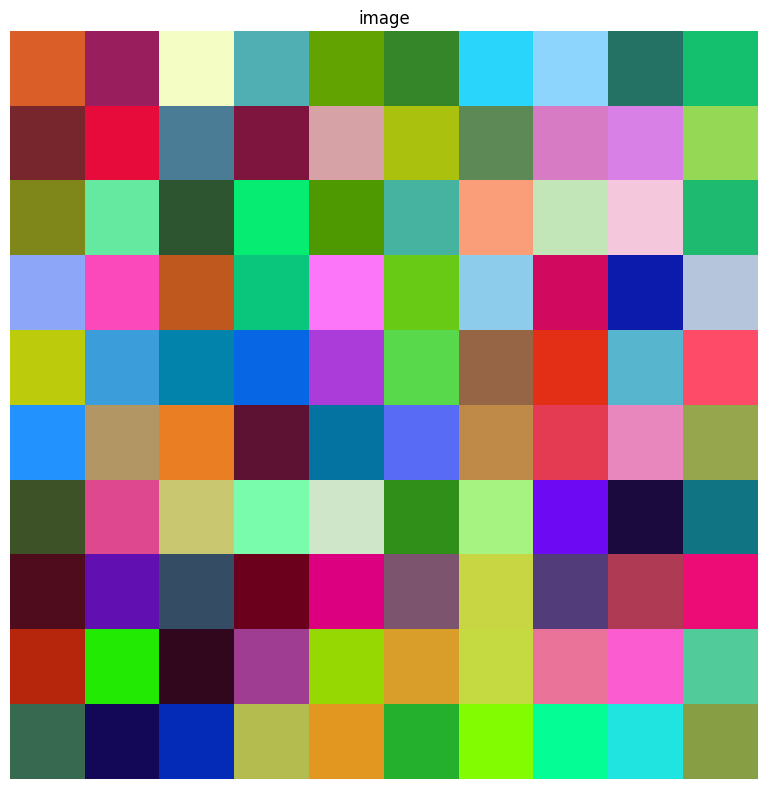

In [17]:
img = sq.im.ImageContainer(image)
img.show()

you basically create an image container with different layers, and you can access specific images by using square brackets

In [20]:
img

ImageContainer[shape=(10, 10), layers=['image']]

In [19]:
img["image"]

<xarray.DataArray 'image' (y: 10, x: 10, z: 1, channels: 3)>
array([[[[0.85654802, 0.37226157, 0.1536129 ]],

        [[0.60084041, 0.11967256, 0.36491936]],

        [[0.95842918, 0.99546447, 0.77210489]],

        [[0.31096151, 0.68766505, 0.70540637]],

        [[0.3878417 , 0.64088863, 0.01072764]],

        [[0.20905766, 0.5250883 , 0.1637513 ]],

        [[0.16590687, 0.83630429, 0.989133  ]],

        [[0.55596943, 0.83906973, 0.99032166]],

        [[0.14159589, 0.44824561, 0.39257272]],

        [[0.08004928, 0.75533017, 0.43377903]]],

...

       [[[0.2163557 , 0.41402609, 0.31763563]],

        [[0.07810839, 0.02983477, 0.34647866]],

        [[0.01903415, 0.16548776, 0.72518332]],

        [[0.70809124, 0.73858039, 0.31715317]],

        [[0.89001946, 0.59383055, 0.12602634]],

        [[0.14371866, 0.69309543, 0.17294394]],

        [[0.5072927 , 0.99177448, 0.0040076 ]],

        [[0.0165798 , 0.99308458, 0.58463883]],

        [[0.12690998, 0.8973022 , 0.8803803 ]],

        [[0.53620041, 0.62179203, 0.27318719]]]])
Coordinates:
  * z        (z) <U1 '0'
Dimensions without coordinates: y, x, channels